## 自动求导
PyTorch 中， 所有神经网络的核心是 autograd 包。autograd包为张量上的所有操作提供了自动求导机制。

### 本节内容：
- autograd的求导机制

- 梯度的反向传播

### Autograd简介
torch.Tensor 是这个包的核心类。如果设置它的属性 .requires_grad 为 True，那么它将会追踪对于该张量的所有操作。当完成计算后可以通过调用 .backward()，来自动计算所有的梯度。这个张量的所有梯度将会自动累加到.grad属性。

> 注意：在 y.backward() 时，如果 y 是标量，则不需要为 backward() 传入任何参数；否则，需要传入一个与 y 同形的Tensor。

requires_grad参数说明：
- requires_grad=True时，表示参数需要参与训练，并在训练过程中进行梯度计算
- requires_grad=False时，表示参数不需要参与训练，可以将代码块包装在 with torch.no_grad(): 中

autograd 要点：
- Tensor 和 Function 互相连接生成了一个无环图 (acyclic graph)，它编码了完整的计算历史。每个张量都有一个.grad_fn属性，该属性引用了创建 Tensor 自身的Function
- 张量是用户手动创建的，即这个张量的grad_fn是 None

In [21]:
from __future__ import print_function
import torch
# 手动创建Tensor ，则grad fun 为None
x = torch.randn(3,3,requires_grad=True)
print(x.grad_fn)

None


In [22]:
# 计算导数
# 设置requires_grad=True用来追踪其计算历史
x = torch.ones(2, 2, requires_grad=True)
print(x)
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [3]:
#y是计算的结果，所以它有grad_fn属性。
y = x**2
print(y)
print(y.grad_fn)

tensor([[1., 1.],
        [1., 1.]], grad_fn=<PowBackward0>)


In [4]:
#.requires_grad_(...) 原地改变了现有张量的requires_grad标志。
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<MulBackward0>) tensor(3., grad_fn=<MeanBackward0>)


In [20]:
# 如果没有指定的话，默认输入的这个标志是 False。
a = torch.randn(2, 2) # 缺失情况下默认 requires_grad = False
b = ((a * 3) / (a - 1))
print(b.requires_grad)

False


### 梯度求解

In [6]:
# 求解out
# 因为 out 是一个标量，因此out.backward()和 out.backward(torch.tensor(1.)) 等价
out.backward()
#d(out)/dx

In [7]:
print(x.grad)

tensor([[3., 3.],
        [3., 3.]])


数学上，若有向量函数$y = f(x)$,
，那么y关于x的梯度就是一个雅可比矩阵： 
 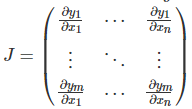
而 torch.autograd 这个包就是用来计算一些雅可比矩阵的乘积的

> 注意：grad在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零

In [8]:
# 再来反向传播⼀一次，注意grad是累加的
out2 = x.sum()
out2.backward()
print(x.grad)

tensor([[4., 4.],
        [4., 4.]])


In [9]:
# 梯度清零 再求导
out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

tensor([[1., 1.],
        [1., 1.]])


In [11]:
x = torch.randn(3, requires_grad=True)
print(x)

y = x * 2
i = 0
# norm y每个元素进行平方，然后对它们求和，最后取平方根 ,L2范式
while y.data.norm() < 1000:
    print(y.data.norm())
    y = y * 2
    i = i + 1
print(y)
print(i)

tensor([-0.5809, -1.0104,  1.2924], requires_grad=True)
tensor(3.4806)
tensor(6.9612)
tensor(13.9224)
tensor(27.8449)
tensor(55.6897)
tensor(111.3795)
tensor(222.7590)
tensor(445.5180)
tensor(891.0359)
tensor([ -594.8848, -1034.6632,  1323.3912], grad_fn=<MulBackward0>)
9


In [12]:
# y 不再是标量。torch.autograd 不能直接计算完整的雅可比矩阵，
#但是如果我们只想要雅可比向量积，只需将这个向量作为参数传给 backward
v = torch.tensor([0.1,1.0,0.0001],dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [13]:
# 也可以通过将代码块包装在 with torch.no_grad(): 中，
#来阻止 autograd 跟踪设置了.requires_grad=True的张量的历史记录。
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


In [24]:
#如果我们想要修改 tensor 的数值，但是又不希望被 autograd 记录(即不会影响反向传播)， 
#那么我们可以对 tensor.data 进行操作
x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.requires_grad)
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
print(y)
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播
print(x) # 更改data的值也会影响tensor的值 
y.backward()

print(x.grad)

tensor([1.])
True
False
tensor([2.], grad_fn=<MulBackward0>)
tensor([1.], requires_grad=True)
tensor([2.])
